# Settings

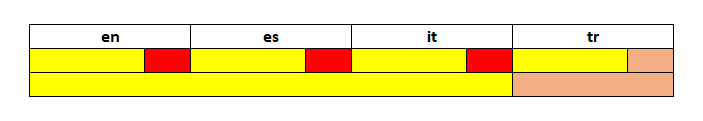

In [1]:
# CONTROLS
MODEL_PREFIX = "V09"
MODEL_NUMBER = MODEL_PREFIX[-2:]
MODEL_NAME = 'distilbert' # options include 'xlm' or 'distilbert'

NUM_EPOCHS = [2, 2, 1]
LR = 5e-5
MAX_SEQ_LEN = 75
SAMPLE_SIZE = 8000
PSUEDO_PROB_THRESH_LOW = 0.04
PSUEDO_PROB_THRESH_HIGH = 0.85

RUN_ON_SAMPLE = 0
ON_KAGGLE = False

if ON_KAGGLE:
    BATCH_SIZE = 64
    PREDICT_BATCH_SIZE = 1024
else:
    BATCH_SIZE = 16
    PREDICT_BATCH_SIZE = 256

TRAIN_SPLIT_RATIO = 0.2
DROPOUT = 0.3
LABEL_SMOOTHING_PARAM = 0.1

In [2]:
if ON_KAGGLE:
    RESULTS_DIR = '../working/'
    DATA_DIR = '../input/jigsaw-multilingual-toxic-comment-classification/'
    if MODEL_NAME == 'xlm':
        MODEL_DIR = '../input/tf-xlm-roberta-base/'
    else:
        MODEL_DIR = '../input/tf-distilbert-base-multilingual-cased/'
else:
    PATH = ".." #"/content/drive/My Drive/Kaggle/jigsaw-multilingual-toxic-comment-classification"
    RESULTS_DIR = PATH+"/results/"
    DATA_DIR = PATH+"/data/"
    if MODEL_NAME == 'xlm':
        MODEL_DIR = PATH+"/models/tf-xlm-roberta-base/"
    else:
        MODEL_DIR = PATH+"/models/distilbert-base-multilingual-cased/"

# Libraries

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold, LeaveOneGroupOut
from sklearn.utils import class_weight

import pickle, os, sys, re, json, gc
from time import time, ctime
from pprint import pprint
from collections import Counter

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, Embedding, Dense, concatenate, MaxPooling2D, Softmax, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Reshape, Activation, Bidirectional, TimeDistributed
from tensorflow.keras.layers import RepeatVector, Multiply, Layer, LeakyReLU, Subtract
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.callbacks import *
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.utils import to_categorical

import tokenizers, transformers
from transformers import *

import tensorflow_addons as tfa
from tensorflow_addons.optimizers import TriangularCyclicalLearningRate

%matplotlib inline

In [4]:
seeded_value = 654123
pd.set_option('display.max_colwidth', None)
np.random.seed(seeded_value)
tf.random.set_seed(seeded_value)

In [5]:
print(ctime(time()))

Fri Jun 19 19:33:02 2020


In [6]:
print([
    tf.__version__,
    transformers.__version__,
    tokenizers.__version__
])

['2.1.0', '2.8.0', '0.5.2']


<a href="https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth"  target="_blank"><h2 id="limiting_gpu_memory_growth" data-text="Limiting GPU memory growth" tabindex="0">Limiting GPU memory growth</h2></a>
<p>By default, TensorFlow maps nearly all of the GPU memory of all GPUs (subject to
<a href="https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#env-vars"><code translate="no" dir="ltr">CUDA_VISIBLE_DEVICES</code></a>) visible to the process. This is done to more efficiently use the relatively precious GPU memory resources on the devices by reducing memory fragmentation. To limit TensorFlow to a specific set of GPUs we use the <code translate="no" dir="ltr">tf.config.experimental.set_visible_devices</code> method.</p>

In [7]:
print(tf.config.experimental.list_logical_devices('CPU'))
print(tf.config.experimental.list_logical_devices('GPU'))
print(tf.config.experimental.list_physical_devices('CPU'))
print(tf.config.experimental.list_physical_devices('GPU'))

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# Import Data

In [9]:
train = pd.read_csv(DATA_DIR+'jigsaw-toxic-comment-train.csv')
validation = pd.read_csv(DATA_DIR+'validation.csv')
test = pd.read_csv(DATA_DIR+'test.csv')
hate_speech = pd.read_csv(DATA_DIR+"extra/hate-speech-dataset-multi-language/cleaned_data_hatespeech.csv")
subtitles = pd.read_csv(DATA_DIR+"extra/open-subtitles-kaggle-dataset/open-subtitles-synthesic.csv")

In [10]:
hate_speech['id'] = np.arange(len(hate_speech))
hate_speech['set'] = 'hate_speech'

subtitles['set'] = 'subtitles'

train['lang'] = 'en'

train['set'] = 'train'
validation['set'] = 'valid'
test['set'] = 'test'

test['toxic'] = 0

In [11]:
print(train.columns)
print(validation.columns)
print(test.columns)
print(hate_speech.columns)
print(subtitles.columns)

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'lang', 'set'],
      dtype='object')
Index(['id', 'comment_text', 'lang', 'toxic', 'set'], dtype='object')
Index(['id', 'content', 'lang', 'set', 'toxic'], dtype='object')
Index(['comment_text', 'toxic', 'lang', 'id', 'set'], dtype='object')
Index(['id', 'comment_text', 'toxic', 'lang', 'token_length', 'set'], dtype='object')


In [12]:
train.lang.unique(), validation.lang.unique(), test.lang.unique(), hate_speech.lang.unique(), subtitles.lang.unique()

(array(['en'], dtype=object),
 array(['es', 'it', 'tr'], dtype=object),
 array(['tr', 'ru', 'it', 'fr', 'pt', 'es'], dtype=object),
 array(['fr', 'en', 'it', 'tr', 'es', 'ru', 'pt'], dtype=object),
 array(['fr', 'pt', 'es', 'tr', 'ru', 'it'], dtype=object))

In [13]:
train.columns = ['id', 'text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'lang', 'set']
validation.columns = ['id', 'text', 'lang', 'toxic', 'set']
test.columns = ['id', 'text', 'lang', 'set', 'toxic']
hate_speech.columns = ['text', 'toxic', 'lang', 'id', 'set']
subtitles.columns = ['id', 'text', 'toxic', 'lang', 'token_length', 'set']

In [14]:
REQ_COLS = ['id', 'set', 'text', 'lang', 'toxic']

In [15]:
train['text'] = train["text"].astype(str)
validation['text'] = validation["text"].astype(str)
test['text'] = test["text"].astype(str)
hate_speech['text'] = hate_speech['text'].astype(str)
subtitles['text'] = subtitles['text'].astype(str)

In [16]:
train.shape, validation.shape, test.shape, hate_speech.shape, subtitles.shape

((223549, 10), (8000, 5), (63812, 5), (117382, 5), (1291949, 6))

In [17]:
data = pd.concat([train[REQ_COLS].sample(SAMPLE_SIZE, random_state=seeded_value),
                  validation[REQ_COLS], 
                  subtitles[REQ_COLS].sample(SAMPLE_SIZE*3, random_state=seeded_value)], axis=0)

In [18]:
data.shape

(26000, 5)

In [19]:
data.sample(2)

,id,set,text,lang,toxic
1196711,en-tr-3876281,subtitles,burası Bai Yuan tapınağı değil mi?,tr,0
5618,5618,valid,"TODO: Bueno, falta terminar algunas definiciones.... Falta darle un formato mas amigable... La sección de enlaces hay que saber que agregar. Quamer.",es,0


In [20]:
data.groupby(["set", "lang"]).agg({'id':'count', 'toxic':np.mean})

id     toxic
set       lang                
subtitles es    2084  0.123800
          fr    2239  0.127289
          it    1048  0.112595
          pt    2500  0.115600
          ru    2927  0.096003
          tr    4202  0.110900
train     en    3000  0.098000
valid     es    2500  0.168800
          it    2500  0.195200
          tr    3000  0.106667

In [21]:
test.groupby(["set", "lang"]).agg({'id':'count', 'toxic':np.mean})

id  toxic
set  lang              
test es     8438      0
     fr    10920      0
     it     8494      0
     pt    11012      0
     ru    10948      0
     tr    14000      0

In [22]:
if RUN_ON_SAMPLE>0:
    data = data.sample(RUN_ON_SAMPLE).copy().reset_index(drop=True)
    test = test.sample(RUN_ON_SAMPLE).copy().reset_index(drop=True)

# Tokenizer, Config & Model Initialization

1. https://arxiv.org/pdf/1911.02116.pdf
2. https://huggingface.co/transformers/model_doc/xlmroberta.html

In [23]:
if MODEL_NAME == 'xlm':
    xlmr_tok = transformers.XLMRobertaTokenizer.from_pretrained(MODEL_DIR)
else:
    xlmr_tok = transformers.DistilBertTokenizer.from_pretrained(MODEL_DIR)

In [24]:
with open(MODEL_DIR+"special_tokens_map.json") as f:
    special_tokens = json.load(f)
xlmr_tok.add_special_tokens(special_tokens)

0

In [25]:
VOCAB_SIZE = xlmr_tok.vocab_size
print(VOCAB_SIZE)

119547


# Tokenization

In [26]:
X_tokens, X_att = [], []
for t in data.text.tolist():
    encoded_text = xlmr_tok.encode_plus(t, pad_to_max_length=True, max_length=MAX_SEQ_LEN)
    X_tokens.append(encoded_text['input_ids'])
    X_att.append(encoded_text['attention_mask'])

X_tokens, X_att, X_lang, Y_toxic, X_set = np.array(X_tokens), np.array(X_att), data['lang'].values, data['toxic'].values, data['set'].values

In [27]:
X_tokens_test, X_att_test = [], []
for t in test.text.tolist():
    encoded_text = xlmr_tok.encode_plus(t, pad_to_max_length=True, max_length=MAX_SEQ_LEN)
    X_tokens_test.append(encoded_text['input_ids'])
    X_att_test.append(encoded_text['attention_mask'])

X_tokens_test, X_att_test = np.array(X_tokens_test), np.array(X_att_test)

print("\n",
      X_tokens_test.shape, "\t: X_tokens_test ", "\n",
      X_att_test.shape, "\t: X_att_test ", "\n"
)


 (63812, 75) 	: X_tokens_test  
 (63812, 75) 	: X_att_test  



In [32]:
if not os.path.exists(DATA_DIR+"ProcessedData.pickle"):
    with open(DATA_DIR+"ProcessedData.pickle", "wb") as f:
        pickle.dump((X_tokens, X_att, X_lang, Y_toxic, X_set, X_tokens_test, X_att_test), f)

In [33]:
if os.path.exists(DATA_DIR+"ProcessedData.pickle"):
    with open(DATA_DIR+"ProcessedData.pickle", "rb") as f:
        X_tokens, X_att, X_lang, Y_toxic, X_set, X_tokens_test, X_att_test = pickle.load(f)

# Model Specifications

In [34]:
def build_model():
    input_sequences = Input((MAX_SEQ_LEN), dtype=tf.int32, name="words")
    input_att_flags = Input((MAX_SEQ_LEN), dtype=tf.int32, name="att_flags")
    
    if MODEL_NAME == 'xlm':
        config = transformers.XLMRobertaConfig.from_pretrained(MODEL_DIR)
        model = transformers.TFXLMRobertaModel.from_pretrained(MODEL_DIR, config=config) # TFXLMRobertaForSequenceClassification
        x = model(inputs=input_sequences, attention_mask=input_att_flags)
    else:
        config = transformers.DistilBertConfig.from_pretrained(MODEL_DIR)
        model = transformers.TFDistilBertModel.from_pretrained(MODEL_DIR) # TFDistilBertForSequenceClassification
        x = model(inputs=input_sequences, attention_mask=input_att_flags)
    
    x1 = tf.keras.layers.Dropout(DROPOUT)(x[0])
    x1 = tf.keras.layers.Conv1D(768, 2, padding='same')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    toxic_output = tf.keras.layers.Activation('sigmoid', name="toxic_output")(x1)
    
    model = Model([input_att_flags, input_sequences],
                  [toxic_output])
    
    return model

In [35]:
model = build_model()

In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              [(None, 75)]         0                                            
__________________________________________________________________________________________________
att_flags (InputLayer)          [(None, 75)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB ((None, 75, 768),)   134734080   words[0][0]                      
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 75, 768)      0           tf_distil_bert_model[0][0]       
______________________________________________________________________________________________

# Cross Validation Strategy

KFold Stratified train-validation split

In [37]:
#NUM_FOLDS = 3
#skf = StratifiedKFold(NUM_FOLDS, shuffle=True, random_state=seeded_value)

Leave one language out split

In [38]:
#logo = LeaveOneGroupOut()
#for t_index, v_index in logo.split(np.arange(X_tokens.shape[0]), np.arange(X_tokens.shape[0]), groups=X_lang):
#    print(X_lang[t_index])
#    #print(np.unique(X_lang[v_index]))

Simple random train-validation split

In [39]:
#t_index, v_index = train_test_split(np.arange(X_tokens.shape[0]), shuffle=True, random_state=seeded_value)

Manual split

In [55]:
t_index, v_index = np.arange(X_tokens.shape[0])[X_set != 'valid'], np.arange(X_tokens.shape[0])[X_set == 'valid']
print(len(t_index), len(v_index))

18000 8000


# Model Fit

<a href="https://keras.io/guides/transfer_learning/#finetuning" target="_blank"><h2 id="finetuning">Fine-tuning</h2></a>
<p>Once your model has converged on the new data, you can try to unfreeze all or part of
 the base model and retrain the whole model end-to-end with a very low learning rate.</p>
 <p>This is an optional last step that can potentially give you incremental improvements.
 It could also potentially lead to quick overfitting -- keep that in mind.</p>
 <p>It is critical to only do this step <em>after</em> the model with frozen layers has been
trained to convergence. If you mix randomly-initialized trainable layers with
trainable layers that hold pre-trained features, the randomly-initialized layers will
cause very large gradient updates during training, which will destroy your pre-trained
 features.</p>
 <p>It's also critical to use a very low learning rate at this stage, because
you are training a much larger model than in the first round of training, on a dataset
 that is typically very small.
As a result, you are at risk of overfitting very quickly if you apply large weight
 updates. Here, you only want to readapt the pretrained weights in an incremental way.</p>

<a href="https://keras.io/guides/transfer_learning/#finetuning" target="_blank"><p><strong>Important note about <code>compile()</code> and <code>trainable</code></strong></p></a>
<p>Calling <code>compile()</code> on a model is meant to "freeze" the behavior of that model. This
 implies that the <code>trainable</code>
attribute values at the time the model is compiled should be preserved throughout the
 lifetime of that model,
until <code>compile</code> is called again. Hence, if you change any <code>trainable</code> value, make sure
 to call <code>compile()</code> again on your
model for your changes to be taken into account.</p>

In [56]:
pred = np.zeros((len(X_tokens), 1))
pred_test = np.zeros((len(X_tokens_test), 1))
timings_dict = {}

In [57]:
num=0
valid_lang='all'
start_time = time()

if num>0:
    del model
    del mcp
    del csvl
    del adam
    del history
    del auc
    gc.collect()
    K.clear_session()

model = build_model()
auc = tf.keras.metrics.AUC()
mcp = ModelCheckpoint(filepath=RESULTS_DIR+MODEL_PREFIX+"BestCheckpoint_"+valid_lang+"_"+str(num)+".h5", monitor='val_auc',
                      verbose=0, save_best_only=True, save_weights_only=True, mode='max', save_freq='epoch')
csvl = CSVLogger(filename=RESULTS_DIR+MODEL_PREFIX+"_LossLogs_"+valid_lang+"_"+str(num)+".csv",
                 separator=",", append=True)

model.layers[3].trainable = False
adam = Adam(learning_rate=LR)
model.compile(loss={"toxic_output":tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING_PARAM)},
              optimizer=adam,
              metrics=['accuracy', auc])

train_time = time()
history = model.fit(x={"att_flags":X_att[t_index],
                       "words":X_tokens[t_index]},
                    y={"toxic_output":Y_toxic[t_index]},
                    validation_data=({"att_flags":X_att[v_index],
                                      "words":X_tokens[v_index]},
                                     {"toxic_output":Y_toxic[v_index]}),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS[0],
                    shuffle=True,
                    verbose=1,
                    callbacks=[mcp, csvl])

Train on 18000 samples, validate on 8000 samples
Epoch 1/2
18000/18000 [==============================] - 228s 13ms/sample - loss: 0.3338 - accuracy: 0.9264 - auc: 0.8882 - val_loss: 0.4531 - val_accuracy: 0.8436 - val_auc: 0.8183
Epoch 2/2
18000/18000 [==============================] - 220s 12ms/sample - loss: 0.2538 - accuracy: 0.9697 - auc: 0.9776 - val_loss: 0.4215 - val_accuracy: 0.8683 - val_auc: 0.8197


In [58]:
pred_initial = model.predict(x = {"att_flags":X_att,
                                  "words":X_tokens},
                             batch_size=PREDICT_BATCH_SIZE)

print("Train ROC-AUC:\t", roc_auc_score(y_true=Y_toxic[t_index], y_score=pred_initial[t_index]))
print("Valid ROC-AUC:\t", roc_auc_score(y_true=Y_toxic[v_index], y_score=pred_initial[v_index]))

print("Train Accuracy:\t", accuracy_score(y_true=Y_toxic[t_index], y_pred=np.where(pred_initial[t_index]>0.5, 1, 0)))
print("Valid Accuracy:\t", accuracy_score(y_true=Y_toxic[v_index], y_pred=np.where(pred_initial[v_index]>0.5, 1, 0)))

print(classification_report(y_true=Y_toxic[t_index], y_pred=np.where(pred_initial[t_index]>0.5, 1, 0)))
print(classification_report(y_true=Y_toxic[v_index], y_pred=np.where(pred_initial[v_index]>0.5, 1, 0)))

Train ROC-AUC:	 0.9977357663486563
Valid ROC-AUC:	 0.8200246184145742
Train Accuracy:	 0.9911111111111112
Valid Accuracy:	 0.86825
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     16009
           1       0.98      0.94      0.96      1991

    accuracy                           0.99     18000
   macro avg       0.99      0.97      0.98     18000
weighted avg       0.99      0.99      0.99     18000

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      6770
           1       0.64      0.33      0.44      1230

    accuracy                           0.87      8000
   macro avg       0.76      0.65      0.68      8000
weighted avg       0.85      0.87      0.85      8000



In [59]:
# Psuedo model fit
psuedo_time = time()

# Accumulate test results after training every fold
pred_psuedo = model.predict(x = {"att_flags":X_att_test,
                                 "words":X_tokens_test},
                            batch_size=PREDICT_BATCH_SIZE).reshape((-1))

In [60]:
test['toxic'] = pred_psuedo

In [61]:
test['toxic'].describe()

count    63812.000000
mean         0.179727
std          0.205050
min          0.016896
25%          0.070306
50%          0.099572
75%          0.168248
max          0.965636
Name: toxic, dtype: float64

In [62]:
test.groupby(["set", "lang"]).agg({'id':'count', 'toxic':np.mean})

id     toxic
set  lang                 
test es     8438  0.253663
     fr    10920  0.175282
     it     8494  0.194327
     pt    11012  0.190162
     ru    10948  0.161233
     tr    14000  0.136032

In [63]:
test.groupby(["set", "lang"]).apply(pd.Series.describe)

id         toxic
set  lang                                  
test es   count   8438.000000   8438.000000
          mean   32405.344039      0.253664
          std    18373.331400      0.276116
          min        7.000000      0.024391
          25%    16665.000000      0.068660
          50%    32646.500000      0.115258
          75%    48250.250000      0.320525
          max    63811.000000      0.965636
     fr   count  10920.000000  10920.000000
          mean   31676.724176      0.175283
          std    18378.065199      0.207053
          min        5.000000      0.016896
          25%    15838.500000      0.062382
          50%    31451.500000      0.090622
          75%    47618.750000      0.167141
          max    63800.000000      0.963515
     it   count   8494.000000   8494.000000
          mean   31916.568048      0.194327
          std    18416.472108      0.213475
          min        2.000000      0.022080
          25%    16118.000000      0.072136
          50%    31959.500000      0.107308
          75%    47677.250000      0.194433
          max    63809.000000      0.960033
     pt   count  11012.000000  11012.000000
          mean   31795.557937      0.190161
          std    18540.963518      0.203421
          min        6.000000      0.020169
          25%    15683.750000      0.079254
          50%    31609.000000      0.108385
          75%    47991.500000      0.183524
          max    63798.000000      0.962209
     ru   count  10948.000000  10948.000000
          mean   31952.666423      0.161233
          std    18307.410026      0.180783
          min        1.000000      0.024888
          25%    16051.750000      0.068504
          50%    32195.000000      0.094989
          75%    47751.750000      0.145069
          max    63803.000000      0.952820
     tr   count  14000.000000  14000.000000
          mean   31825.560000      0.136032
          std    18477.674436      0.144263
          min        0.000000      0.020852
          25%    15613.750000      0.070320
          50%    31902.500000      0.094005
          75%    47873.500000      0.130865
          max    63810.000000      0.948377

In [64]:
Y_toxic_psuedo = np.where(pred_psuedo >= PSUEDO_PROB_THRESH_HIGH, 1, 0)
psuedo_flag = (pred_psuedo >= PSUEDO_PROB_THRESH_HIGH) | (pred_psuedo <= PSUEDO_PROB_THRESH_LOW)

print("Number of psuedo samples available:", sum(psuedo_flag))
print("Psuedo Toxicity:", sum(Y_toxic_psuedo))
print(Counter(test.lang.values))
print(Counter(test.lang.values[psuedo_flag]))

X_att_psuedo = np.concatenate((X_att[t_index], X_att_test[psuedo_flag]))
X_tokens_psuedo = np.concatenate((X_tokens[t_index], X_tokens_test[psuedo_flag]))
Y_toxic_psuedo = np.concatenate((Y_toxic[t_index], Y_toxic_psuedo[psuedo_flag]))

shuffled_idxs = np.arange(Y_toxic_psuedo.shape[0])
np.random.shuffle(shuffled_idxs)

model.layers[3].trainable = False
adam = Adam(learning_rate=LR)
model.compile(loss={"toxic_output":tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING_PARAM)},
              optimizer=adam,
              metrics=['accuracy', auc])

history = model.fit(x={"att_flags":X_att_psuedo[shuffled_idxs],
                       "words":X_tokens_psuedo[shuffled_idxs]},
                    y={"toxic_output":Y_toxic_psuedo[shuffled_idxs]},
                    validation_data=({"att_flags":X_att[v_index],
                                      "words":X_tokens[v_index]},
                                     {"toxic_output":Y_toxic[v_index]}),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS[1],
                    shuffle=True,
                    verbose=1,
                    callbacks=[mcp, csvl])

model.layers[3].trainable = True
adam = Adam(learning_rate=LR*0.001)
model.compile(loss={"toxic_output":tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING_PARAM)},
              optimizer=adam,
              metrics=['accuracy', auc])

history = model.fit(x={"att_flags":X_att_psuedo[shuffled_idxs],
                       "words":X_tokens_psuedo[shuffled_idxs]},
                    y={"toxic_output":Y_toxic_psuedo[shuffled_idxs]},
                    validation_data=({"att_flags":X_att[v_index],
                                      "words":X_tokens[v_index]},
                                     {"toxic_output":Y_toxic[v_index]}),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS[2],
                    shuffle=True,
                    verbose=1,
                    callbacks=[mcp, csvl])

Number of psuedo samples available: 3272
Psuedo Toxicity: 1750
Counter({'tr': 14000, 'pt': 11012, 'ru': 10948, 'fr': 10920, 'it': 8494, 'es': 8438})
Counter({'es': 931, 'fr': 753, 'it': 423, 'pt': 409, 'ru': 381, 'tr': 375})
Train on 21272 samples, validate on 8000 samples
Epoch 1/2
21272/21272 [==============================] - 289s 14ms/sample - loss: 0.2274 - accuracy: 0.9847 - auc: 0.9950 - val_loss: 0.4792 - val_accuracy: 0.8534 - val_auc: 0.8280
Epoch 2/2
21272/21272 [==============================] - 277s 13ms/sample - loss: 0.2153 - accuracy: 0.9914 - auc: 0.9983 - val_loss: 0.5702 - val_accuracy: 0.8181 - val_auc: 0.7976
Train on 21272 samples, validate on 8000 samples
21272/21272 [==============================] - 289s 14ms/sample - loss: 0.2048 - accuracy: 0.9973 - auc: 0.9999 - val_loss: 0.5461 - val_accuracy: 0.8209 - val_auc: 0.7985


In [65]:
infer_time = time()

# Loading best weights per fold
model.load_weights(RESULTS_DIR+MODEL_PREFIX+"BestCheckpoint_"+valid_lang+"_"+str(num)+".h5")

pred += model.predict(x = {"att_flags":X_att,
                                "words":X_tokens},
                           batch_size=PREDICT_BATCH_SIZE)

print("Train ROC-AUC:\t", roc_auc_score(y_true=Y_toxic[t_index], y_score=pred[t_index]))
print("Valid ROC-AUC:\t", roc_auc_score(y_true=Y_toxic[v_index], y_score=pred[v_index]))

print("Train Accuracy:\t", accuracy_score(y_true=Y_toxic[t_index], y_pred=np.where(pred[t_index]>0.5, 1, 0)))
print("Valid Accuracy:\t", accuracy_score(y_true=Y_toxic[v_index], y_pred=np.where(pred[v_index]>0.5, 1, 0)))

print(classification_report(y_true=Y_toxic[t_index], y_pred=np.where(pred[t_index]>0.5, 1, 0)))
print(classification_report(y_true=Y_toxic[v_index], y_pred=np.where(pred[v_index]>0.5, 1, 0)))

# Accumulate test results after training every fold

pred_test += model.predict(x = {"att_flags":X_att_test,
                                "words":X_tokens_test},
                           batch_size=PREDICT_BATCH_SIZE)

end_time = time()
timings_dict.update({num:{
    'start_time' : ctime(start_time),
    'train_time' : ctime(train_time),
    'infer_time' : ctime(infer_time),
    'psuedo_time' : ctime(psuedo_time),
    'end_time' : ctime(end_time),
}})

Train ROC-AUC:	 0.9992279895045226
Valid ROC-AUC:	 0.8278962664072725
Train Accuracy:	 0.9944444444444445
Valid Accuracy:	 0.853375
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16009
           1       0.98      0.97      0.97      1991

    accuracy                           0.99     18000
   macro avg       0.99      0.98      0.99     18000
weighted avg       0.99      0.99      0.99     18000

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      6770
           1       0.52      0.54      0.53      1230

    accuracy                           0.85      8000
   macro avg       0.72      0.73      0.72      8000
weighted avg       0.86      0.85      0.85      8000



In [66]:
pd.DataFrame.from_dict(timings_dict)

,0
end_time,Fri Jun 19 20:13:22 2020
infer_time,Fri Jun 19 20:09:45 2020
psuedo_time,Fri Jun 19 19:52:58 2020
start_time,Fri Jun 19 19:44:24 2020
train_time,Fri Jun 19 19:44:26 2020


In [67]:
test['toxic'] = pred_test

In [68]:
test[['id','toxic']].to_csv(RESULTS_DIR+"submission.csv", index=False)

In [69]:
test['toxic'].describe()

count    63812.000000
mean         0.227771
std          0.301072
min          0.013343
25%          0.053583
50%          0.076167
75%          0.203183
max          0.984382
Name: toxic, dtype: float64

In [70]:
test.groupby(["set", "lang"]).agg({'id':'count', 'toxic':np.mean})

id     toxic
set  lang                 
test es     8438  0.355292
     fr    10920  0.252624
     it     8494  0.283121
     pt    11012  0.207749
     ru    10948  0.208045
     tr    14000  0.129121

In [71]:
test.groupby(["set", "lang"]).apply(pd.Series.describe)

id         toxic
set  lang                                  
test es   count   8438.000000   8438.000000
          mean   32405.344039      0.355292
          std    18373.331400      0.372974
          min        7.000000      0.013879
          25%    16665.000000      0.056060
          50%    32646.500000      0.106069
          75%    48250.250000      0.778454
          max    63811.000000      0.984071
     fr   count  10920.000000  10920.000000
          mean   31676.724176      0.252624
          std    18378.065199      0.324163
          min        5.000000      0.018948
          25%    15838.500000      0.049302
          50%    31451.500000      0.073242
          75%    47618.750000      0.319326
          max    63800.000000      0.984382
     it   count   8494.000000   8494.000000
          mean   31916.568048      0.283121
          std    18416.472108      0.332654
          min        2.000000      0.017021
          25%    16118.000000      0.057107
          50%    31959.500000      0.091229
          75%    47677.250000      0.464111
          max    63809.000000      0.983352
     pt   count  11012.000000  11012.000000
          mean   31795.557937      0.207749
          std    18540.963518      0.286818
          min        6.000000      0.020407
          25%    15683.750000      0.052257
          50%    31609.000000      0.070982
          75%    47991.500000      0.155167
          max    63798.000000      0.981881
     ru   count  10948.000000  10948.000000
          mean   31952.666423      0.208045
          std    18307.410026      0.276383
          min        1.000000      0.018885
          25%    16051.750000      0.054783
          50%    32195.000000      0.074878
          75%    47751.750000      0.170231
          max    63803.000000      0.982071
     tr   count  14000.000000  14000.000000
          mean   31825.560000      0.129121
          std    18477.674436      0.182503
          min        0.000000      0.013343
          25%    15613.750000      0.054110
          50%    31902.500000      0.072073
          75%    47873.500000      0.102602
          max    63810.000000      0.979828

In [72]:
print(ctime(time()))

Fri Jun 19 20:13:22 2020
